# Construct a custom Environment for Pair Trading

Some examples on the market
* [custom env example](https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/sb3/5_custom_gym_env.ipynb#scrollTo=RqxatIwPOXe_)
* [StockTradingEnv by Adam King](https://github.com/notadamking/Stock-Trading-Environment)
* [FinRL](https://github.com/AI4Finance-Foundation/FinRL)

Target is to construct a custom Env for pair trading

This env restrict the behaviour of RL learner to pair trading only

## 1. Import the Custom Trading Env

In [1]:
import os
import csv
import pickle
import pandas as pd
import quantstats as qs
import matplotlib.pyplot as plt
from tqdm import trange
from stable_baselines3 import PPO, A2C, DQN

from params import *
from utils.read2df import read2df, unify_dfs
from utils.clearlogs import clear_logs
from utils.rlmetrics import get_return, get_metrics
from envs.env_rl_restrict_thres import RL_Restrict_TradeEnv

folder_path = f"result/rl-restrict-thres"
os.makedirs(folder_path, exist_ok=True)

## 2. Prepare Trading Data
Load data from `preliminaries.ipynb`

In [2]:
with open('result/cointncorr.pickle', 'rb') as pk:
    cointncorr = pickle.load(pk)

with open('result/gridsearch/best_res.pickle', 'rb') as pk:
    best_profit, best_params = pickle.load(pk)

dfs = read2df(symbols=cointncorr[0], freqs={cointncorr[1]: freqs[cointncorr[1]]}, marketType='spot')
tics, df = unify_dfs(dfs, symbols=cointncorr[0], period=best_params['period'])

In [3]:
df.tail(20)

,time,close0,itvl,datetime,close1,spread,zscore
87820,1701387659999,0.000530,1m,2023-11-30 23:40:59.999,0.000615,-0.000084,-0.524611
87821,1701387719999,0.000530,1m,2023-11-30 23:41:59.999,0.000615,-0.000084,-0.382367
87822,1701387779999,0.000531,1m,2023-11-30 23:42:59.999,0.000615,-0.000084,-0.150181
87823,1701387839999,0.000531,1m,2023-11-30 23:43:59.999,0.000615,-0.000084,-0.151877
87824,1701387899999,0.000531,1m,2023-11-30 23:44:59.999,0.000615,-0.000084,-0.233467
87825,1701387959999,0.000531,1m,2023-11-30 23:45:59.999,0.000615,-0.000084,-0.238003
87826,1701388019999,0.000531,1m,2023-11-30 23:46:59.999,0.000615,-0.000084,-0.236771
87827,1701388079999,0.000530,1m,2023-11-30 23:47:59.999,0.000615,-0.000084,-0.362875
87828,1701388139999,0.000530,1m,2023-11-30 23:48:59.999,0.000615,-0.000085,-0.866649
87829,1701388199999,0.000530,1m,2023-11-30 23:49:59.999,0.000615,-0.000085,-0.896373


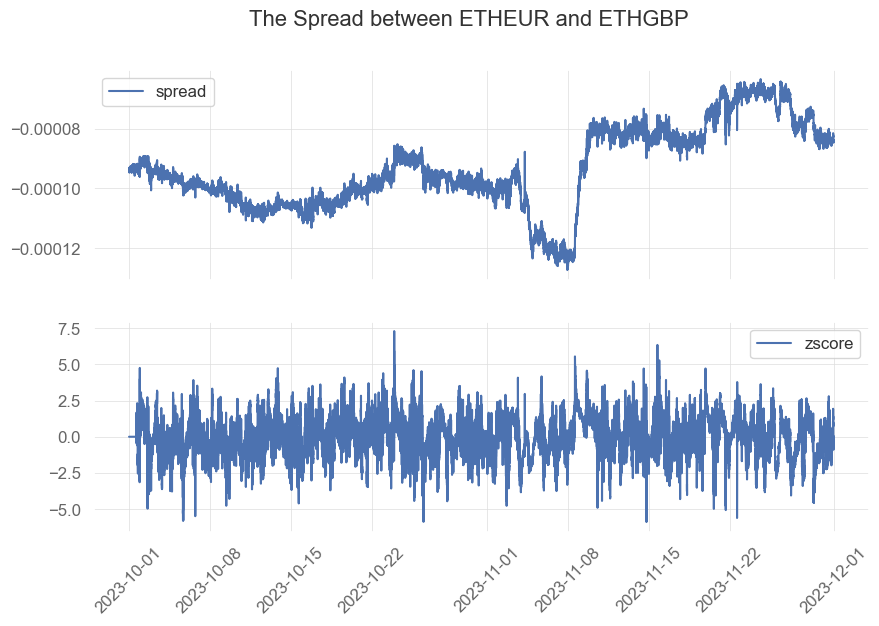

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(df['datetime'], df['spread'], label='spread')
ax2.plot(df['datetime'], df['zscore'], label='zscore')

ax1.legend()
ax2.legend()
plt.suptitle(f'The Spread between {cointncorr[0][0]} and {cointncorr[0][1]}')

plt.xticks(rotation=45)
plt.show()

In [5]:
train = df[(df['datetime'] >= datetime.strptime(start_date, date_format)) & (df['datetime'] < datetime.strptime(trade_date, date_format))]
test = df[(df['datetime'] >= datetime.strptime(trade_date, date_format)) & (df['datetime'] < datetime.strptime(end_date, date_format))]

max_train_len = int((len(train)-best_params['period']) * 0.95)
print(f"The length of our training data: {len(train)}")

The length of our training data: 44640


## 3. Check with baselin3 `env_checker`

Check if the env meets the requirements of `stable_baseline3`

In [6]:
from stable_baselines3.common.env_checker import check_env

env = RL_Restrict_TradeEnv(train)
obs, _ = env.reset()
check_env(env)

Tensorboard

## 4. Train the Model with Trading Env

In [7]:
log_path = f"logs/restrict_thres/"
clear_logs(log_path)

# Read more about tensorboard
# https://github.com/tensorflow/tensorboard/blob/master/README.md
# https://www.tensorflow.org/tensorboard/get_started

Deleted: logs/restrict_thres/A2C_1
Deleted: logs/restrict_thres/DQN_1
Deleted: logs/restrict_thres/PPO_1


In [8]:
'''PPO'''

model_ppo = PPO("MultiInputPolicy", env, verbose=0, gamma=1, batch_size=256, tensorboard_log=log_path)
model_ppo.learn(total_timesteps=max_train_len, progress_bar=True)
model_ppo.save(f"{folder_path}/ppo_pairtrading")

Output()

In [9]:
'''A2C'''

model_a2c = A2C("MultiInputPolicy", env, verbose=0, gamma=1, tensorboard_log=log_path)
model_a2c.learn(total_timesteps=max_train_len, progress_bar=True)
model_a2c.save(f"{folder_path}/a2c_pairtrading")

Output()

In [10]:
'''DQN'''

model_dqn = DQN("MultiInputPolicy", env, verbose=0, gamma=1, batch_size=256, tensorboard_log=log_path)
model_dqn.learn(total_timesteps=max_train_len, progress_bar=True)
model_dqn.save(f"{folder_path}/dqn_pairtrading")

Output()

## 5. Create the Custom Test Env

In [11]:
test_env_ppo = RL_Restrict_TradeEnv(test, model=f"{folder_path}/networth_ppo.csv", verbose=1)
test_env_a2c = RL_Restrict_TradeEnv(test, model=f"{folder_path}/networth_a2c.csv", verbose=1)
test_env_dqn = RL_Restrict_TradeEnv(test, model=f"{folder_path}/networth_dqn.csv", verbose=1)

In [12]:
max_test_len = int(len(test) * 0.95)
print(f"The length of our test data: {max_test_len}")

The length of our test data: 41040


## 6. Test Env with Trained Model

In [13]:
try:
    os.remove(f"{folder_path}/networth_ppo.csv")
except OSError:
    pass

obs, _ = test_env_ppo.reset()

for i in trange(max_test_len):
    action, _states = model_ppo.predict(obs)
    obs, rewards, terminated, truncated, info = test_env_ppo.step(action)
    if i%int(max_test_len/10)==0:
        test_env_ppo.render()

test_env_ppo.close()

  0%|                                                                                                                                                        | 15/41040 [00:00<04:46, 143.15it/s]

signal: {'position': 1, 'zone': 4, 'zscore': array([-2.00894742])}, action: 2, reward:0.1, networth: 1.0


 10%|███████████████                                                                                                                                       | 4119/41040 [00:33<04:55, 124.93it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.1520439])}, action: 1, reward:0.1, networth: 1.0129


 20%|██████████████████████████████                                                                                                                        | 8232/41040 [01:04<04:33, 119.99it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.08627466])}, action: 1, reward:0.1, networth: 1.0175


 30%|████████████████████████████████████████████▋                                                                                                        | 12325/41040 [01:34<03:34, 133.67it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.04332489])}, action: 1, reward:0.1, networth: 1.0183


 40%|███████████████████████████████████████████████████████████▋                                                                                         | 16435/41040 [02:05<03:02, 134.93it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.53540716])}, action: 1, reward:0.1, networth: 1.0314


 50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 20536/41040 [02:36<02:30, 136.13it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.02932751])}, action: 1, reward:0.1, networth: 1.0587


 60%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 24643/41040 [03:06<02:02, 133.62it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.38472686])}, action: 1, reward:0.1, networth: 1.0797


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 28749/41040 [03:37<01:32, 133.53it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.68014561])}, action: 1, reward:0.1, networth: 1.0918


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 32851/41040 [04:07<01:01, 132.54it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.60771416])}, action: 1, reward:0.1, networth: 1.1065


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 36958/41040 [04:38<00:30, 133.24it/s]

signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.30703784])}, action: 2, reward:0.1, networth: 1.1132


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41040/41040 [05:09<00:00, 132.74it/s]

Finished
networth: 1.1184340338422554


In [14]:
try:
    os.remove(f"{folder_path}/networth_a2c.csv")
except OSError:
    pass

obs, _ = test_env_a2c.reset()

for i in trange(max_test_len):
    action, _states = model_a2c.predict(obs)
    obs, rewards, terminated, truncated, info = test_env_a2c.step(action)
    if i%int(max_test_len/10)==0:
        test_env_a2c.render()

test_env_a2c.close()

  0%|                                                                                                                                                        | 14/41040 [00:00<04:55, 138.62it/s]

signal: {'position': 1, 'zone': 4, 'zscore': array([-2.00894742])}, action: 1, reward:0.0, networth: 1.0


 10%|███████████████                                                                                                                                       | 4124/41040 [00:34<05:14, 117.41it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.1520439])}, action: 1, reward:0.1, networth: 1.0101


 20%|██████████████████████████████                                                                                                                        | 8228/41040 [01:06<04:11, 130.60it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.08627466])}, action: 1, reward:0.1, networth: 1.0123


 30%|████████████████████████████████████████████▊                                                                                                        | 12332/41040 [01:37<03:34, 133.66it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.04332489])}, action: 1, reward:0.1, networth: 1.025


 40%|███████████████████████████████████████████████████████████▋                                                                                         | 16440/41040 [02:08<03:00, 136.58it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.53540716])}, action: 1, reward:0.1, networth: 1.0308


 50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 20545/41040 [02:40<02:33, 133.42it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.02932751])}, action: 1, reward:0.1, networth: 1.049


 60%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 24647/41040 [03:11<02:02, 134.33it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.38472686])}, action: 1, reward:0.1, networth: 1.057


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 28748/41040 [03:41<01:31, 134.24it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.68014561])}, action: 1, reward:0.1, networth: 1.0625


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 32852/41040 [04:12<01:00, 134.28it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.60771416])}, action: 1, reward:0.1, networth: 1.0681


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 36959/41040 [04:43<00:30, 132.28it/s]

signal: {'position': array(1, dtype=int64), 'zone': 4, 'zscore': array([-2.30703784])}, action: 1, reward:0.0, networth: 1.0739


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41040/41040 [05:13<00:00, 130.75it/s]

Finished
networth: 1.0779680124539703


In [15]:
try:
    os.remove(f"{folder_path}/networth_dqn.csv")
except OSError:
    pass

obs, _ = test_env_dqn.reset()

for i in trange(max_test_len):
    action, _states = model_dqn.predict(obs)
    obs, rewards, terminated, truncated, info = test_env_dqn.step(action)
    if i%int(max_test_len/10)==0:
        test_env_dqn.render()

test_env_dqn.close()

  0%|                                                                                                                                                        | 17/41040 [00:00<04:09, 164.57it/s]

signal: {'position': 1, 'zone': 4, 'zscore': array([-2.00894742])}, action: 1, reward:0.0, networth: 1.0


 10%|███████████████                                                                                                                                       | 4123/41040 [00:32<05:01, 122.47it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.1520439])}, action: 1, reward:0.1, networth: 1.0012


 20%|██████████████████████████████                                                                                                                        | 8231/41040 [00:59<03:22, 161.90it/s]

signal: {'position': array(0, dtype=int64), 'zone': 2, 'zscore': array([0.08627466])}, action: 1, reward:0.101, networth: 1.0018


 30%|████████████████████████████████████████████▊                                                                                                        | 12335/41040 [01:25<03:01, 158.47it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.04332489])}, action: 1, reward:0.1, networth: 1.0029


 40%|███████████████████████████████████████████████████████████▋                                                                                         | 16447/41040 [01:51<02:34, 158.93it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.53540716])}, action: 1, reward:0.1, networth: 1.0026


 50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 20542/41040 [02:16<02:08, 159.62it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.02932751])}, action: 1, reward:0.1, networth: 1.0028


 60%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 24644/41040 [02:42<01:42, 160.61it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.38472686])}, action: 1, reward:0.1, networth: 1.0016


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 28765/41040 [03:08<01:15, 161.85it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.68014561])}, action: 1, reward:0.1, networth: 1.0008


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 32852/41040 [03:33<00:51, 160.31it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.60771416])}, action: 1, reward:0.1, networth: 1.002


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 36956/41040 [04:00<00:26, 156.73it/s]

signal: {'position': array(1, dtype=int64), 'zone': 4, 'zscore': array([-2.30703784])}, action: 1, reward:0.0, networth: 1.0015


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41040/41040 [04:25<00:00, 154.70it/s]

Finished
networth: 0.9998739124226801


### Analyze with Quanstats

In [16]:
os.remove(f"{folder_path}/networth_experiment.csv") if os.path.exists(f"{folder_path}/networth_experiment.csv") else None

csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

best_res, best_model = None, None
for file_name in csv_files:
    file_path = os.path.join(folder_path, file_name)
    
    with open(file_path, 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        
        # Loop through the lines in the CSV file
        last_line = None
        for row in csv_reader:
            last_line = row  # Update last_line with the current row
    
    if best_res is None or float(best_res) < float(last_line[1]):
        best_res = last_line[1]
        best_model = file_name

    print(f"The ending capital of {file_name} is {last_line[0:2]}")

print(f"The best model is {best_model}")

The ending capital of networth_a2c.csv is ['2023-11-30 03:00:59.999000', '1.0779680124539703']
The ending capital of networth_dqn.csv is ['2023-11-30 03:00:59.999000', '0.9998739124226801']
The ending capital of networth_ppo.csv is ['2023-11-30 03:00:59.999000', '1.1184340338422554']
The best model is networth_ppo.csv


In [17]:
best_return = get_return(f'{folder_path}/{best_model}')
get_metrics(best_return)

len(best_return)

Compound annual growth rate: 331%
Total orders count: 41038
Total long action: 6123
Total short action: 6421
Won orders count: 6123
Lost orders count: 6421
Win/Loss order ratio: 0.9535897835228158
Max win: values      1.118903
action      2.000000
zscore      5.549151
position    2.000000
price0      0.000595
price1      0.000703
pnl         0.000773
returns     0.000951
dtype: float64
Max Loss: values      0.999754
action      0.000000
zscore     -5.509726
position    0.000000
price0      0.000500
price1      0.000579
pnl        -0.002496
returns    -0.000760
dtype: float64
Avg order pnl: -2.8870778560289956e-06
Avg order pnl won: -1.846363951416872e-07
Avg order pnl lost: -1.565717372621444e-05
Avg long order pnl: -9.41012056172571e-06
Avg short order pnl: -9.381257656032232e-06


41038

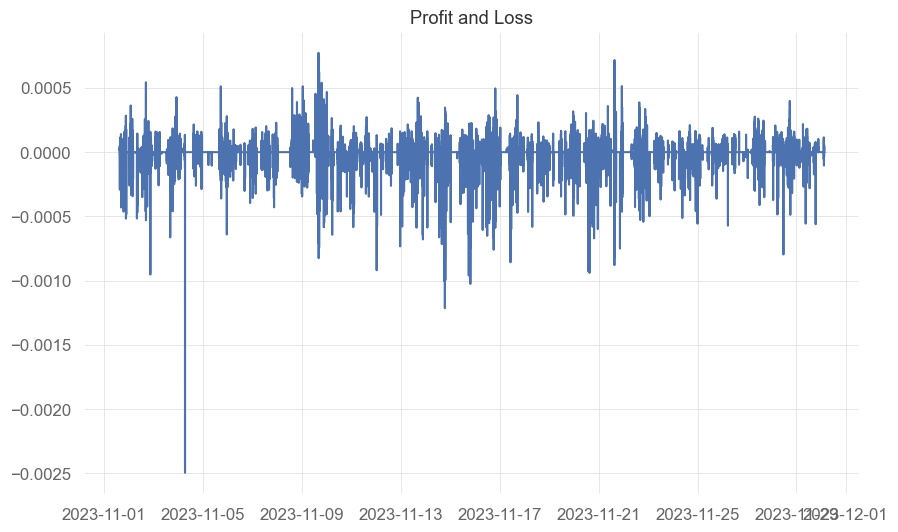

In [18]:
fig, ax = plt.subplots()

ax.set_title("Profit and Loss")
ax.plot(best_return['pnl'])

plt.show()

                           Strategy
-------------------------  ----------
Start Period               2023-11-01
End Period                 2023-11-30
Risk-Free Rate             0.0%
Time in Market             31.0%

Cumulative Return          11.84%
CAGR﹪                     173.84%

Sharpe                     0.77
Prob. Sharpe Ratio         100.0%
Smart Sharpe               0.71
Sortino                    1.43
Smart Sortino              1.31
Sortino/√2                 1.01
Smart Sortino/√2           0.93
Omega                      1.35

Max Drawdown               -0.48%
Longest DD Days            2
Volatility (ann.)          0.09%
Calmar                     364.01
Skew                       5.59
Kurtosis                   145.59

Expected Daily %           0.0%
Expected Monthly %         11.84%
Expected Yearly %          11.84%
Kelly Criterion            13.35%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.01%
Expected Shortfall (cVaR)  -0.01%

Max Consecutive Wins    

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2023-11-08,2023-11-09,2023-11-10,2,-0.477558,-0.404780
2,2023-11-04,2023-11-04,2023-11-05,2,-0.200429,-0.171886
3,2023-11-21,2023-11-21,2023-11-21,1,-0.158150,-0.116842
4,2023-11-03,2023-11-04,2023-11-04,1,-0.145305,-0.142339
5,2023-11-27,2023-11-27,2023-11-27,1,-0.138237,-0.135482


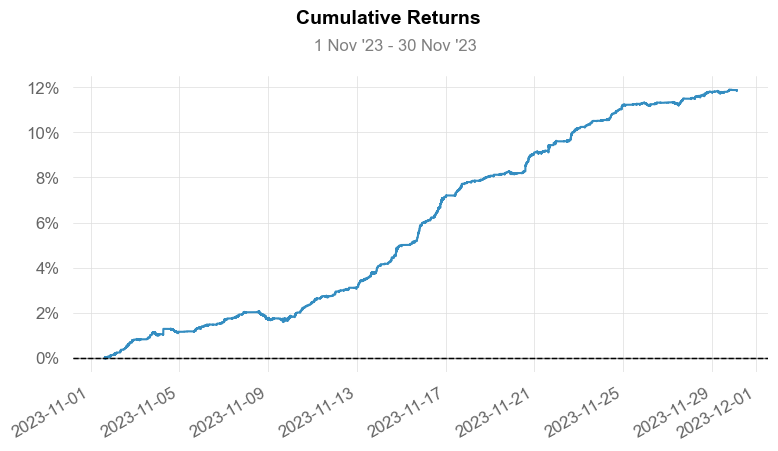

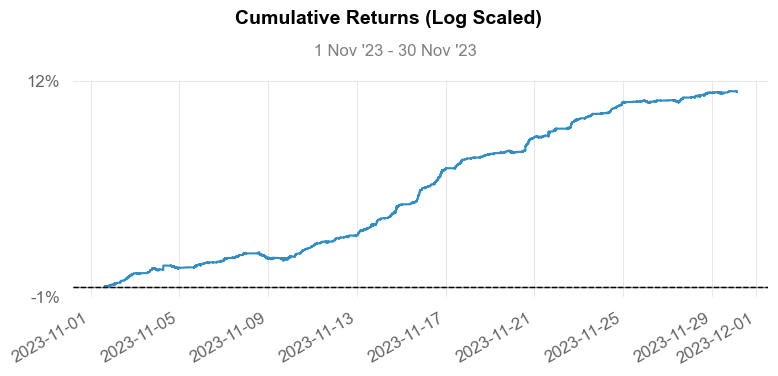

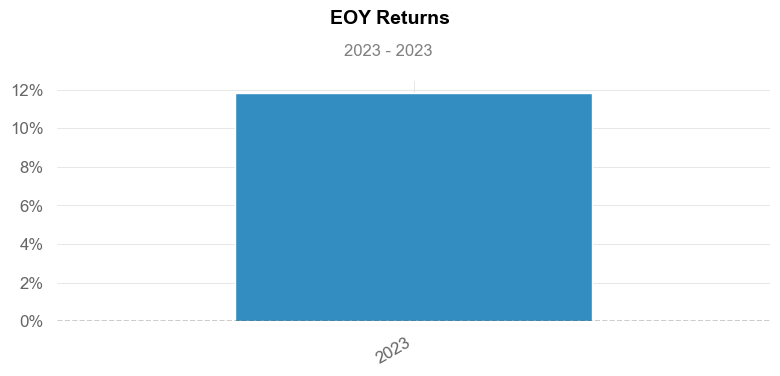

C:\Users\hyan212\Miniconda3\envs\btrl\lib\site-packages\quantstats\_plotting\core.py:516: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  _sns.kdeplot(data=combined_returns, color="black", ax=ax)


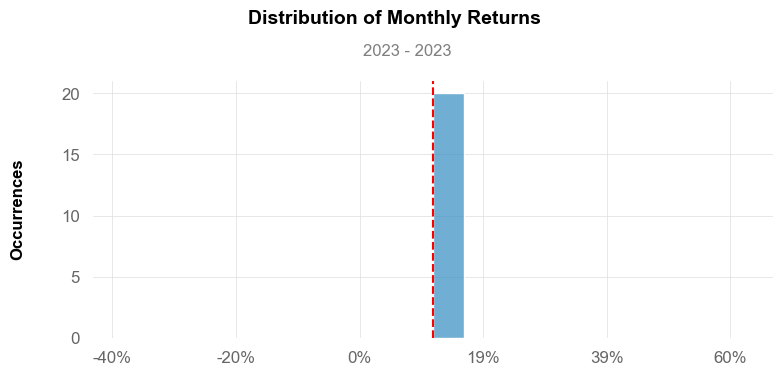

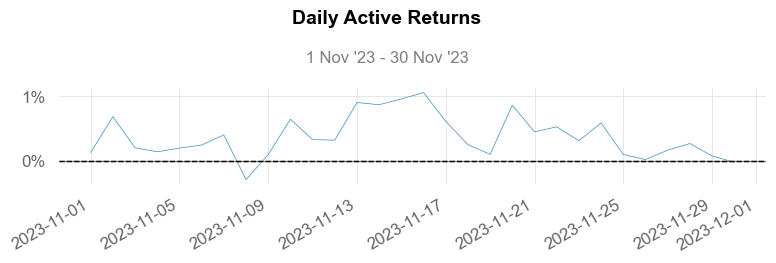

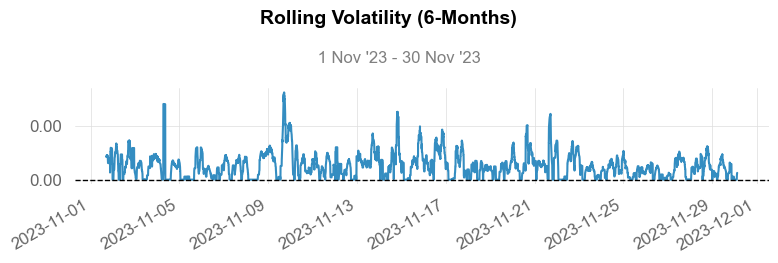

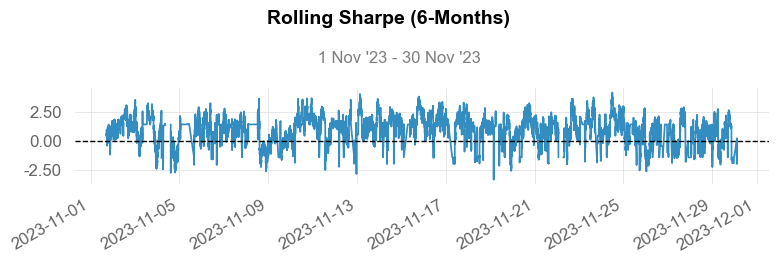

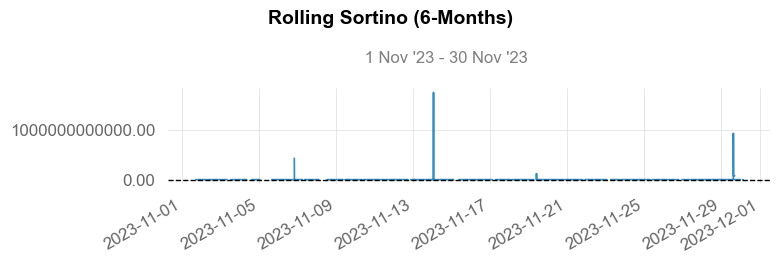

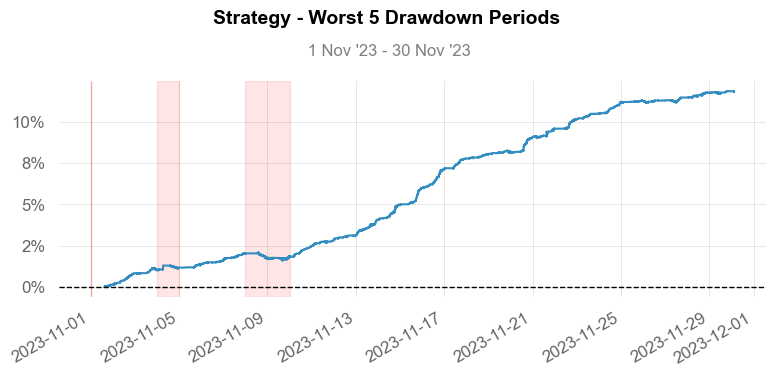

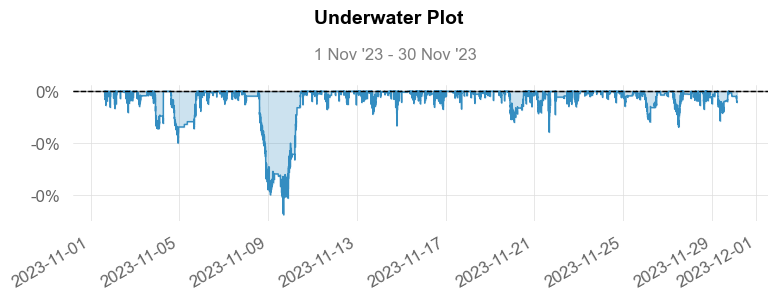

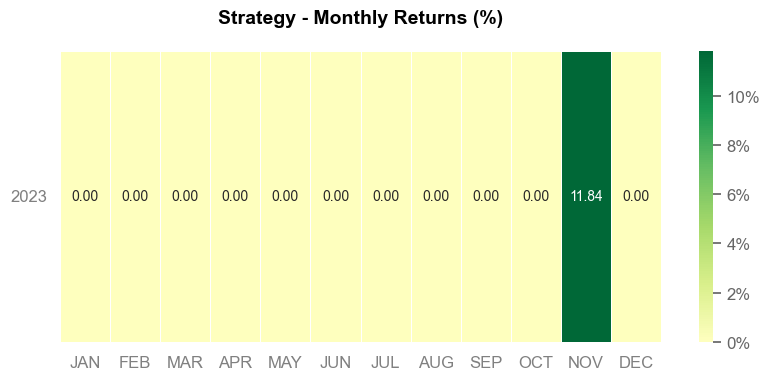

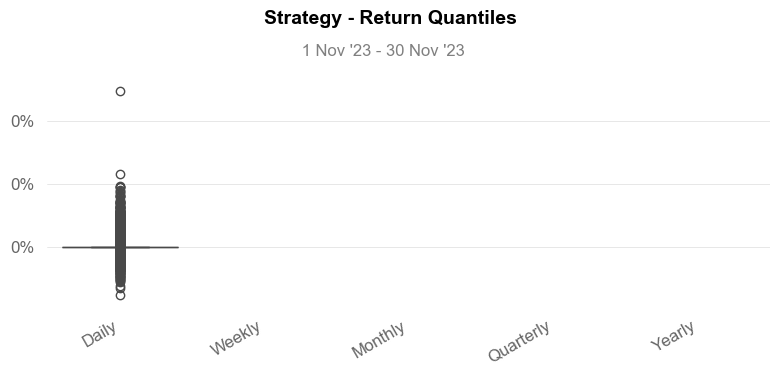

In [19]:
qs.reports.full(best_return['returns'])